Using different databases from the US Department of transportation I'm going to try to answer some questions I have about airlines and flights, mostly relating to delays and onTime data.
The first database I will look into contains statistics about a flight's timing (delay, taxi time...).

As there are millions of flights in this dataset, first I will look at a random day, April 2nd.


http://www.transtats.bts.gov/Fields.asp?Table_ID=236

The data files used are not uploaded in this repo and need to be downloaded here:
http://stat-computing.org/dataexpo/2009/the-data.html (2003.csv)
http://openflights.org/data.html (airports.dat)

In [279]:
import pandas as pd
import numpy as np
import math
import datetime
 
headers = ["UniqueCarrier", "Year", "Month", "DayofMonth", "DepTime", "ArrTime", "FlightNum", "TailNum", "Origin", "Dest", "ArrDelay", "TaxiIn", "TaxiOut"]

csv = "2003.csv"
flights = pd.read_csv(csv,usecols=headers,  encoding="850")
flights = flights.dropna()
flights = flights[np.isfinite(flights['ArrTime'])]
mo = flights.Month == 2 
day = flights.DayofMonth == 3
fl = flights[mo&day]
print(len(flights), len(fl))

cols = ["name", "city", "country", "code", "lat", "long", "altitude", "tz", "dst", "tzName"]
airports = pd.read_csv("airports.dat", header=0, names=cols)
fl.head()

(6375631, 17685)


,Year,Month,DayofMonth,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,ArrDelay,Origin,Dest,TaxiIn,TaxiOut
552117,2003,2,3,1344,1458,UA,934,N933UA,1,LAS,LAX,4,24
552145,2003,2,3,1805,1903,UA,935,N921UA,-10,LAX,LAS,4,10
552173,2003,2,3,1417,2016,UA,938,N555UA,14,SEA,ORD,4,11
552227,2003,2,3,1721,1829,UA,941,N341UA,16,ORD,MSP,5,8
552254,2003,2,3,1446,1834,UA,942,N331UA,84,DEN,ORD,3,34


The date is split up among month, year, DayOfMonth columns, so let's combine. Also, turn the integer ArrTime and DepTimes into actual time objects.

In [280]:
def getTimeFromFloat(tm):
    tm = str(tm).rstrip('0').rstrip('.')
    
    if int(tm) >= 2400:
        tm = str(int(tm)-2400)    
    
    while len(tm) < 4:
        tm = '0' + tm
    
    tm = datetime.datetime.strptime(tm, '%H%M').time()
    return tm

def addDate(rw):
    rw['ArrTime'] = getTimeFromFloat(rw['ArrTime'])
    rw['DepTime'] = getTimeFromFloat(rw['DepTime'])
    rw['date'] = pd.to_datetime(str(rw.Year) +"-"+ str(rw.Month) + "-"+ str(rw.DayofMonth))
    rw.drop(["Year", "Month", "DayofMonth"])
    return rw

fl = fl.apply(addDate, axis=1)
fl.head()

,Year,Month,DayofMonth,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,ArrDelay,Origin,Dest,TaxiIn,TaxiOut,date
552117,2003,2,3,13:44:00,14:58:00,UA,934,N933UA,1,LAS,LAX,4,24,1044230400000000000
552145,2003,2,3,18:05:00,19:03:00,UA,935,N921UA,-10,LAX,LAS,4,10,1044230400000000000
552173,2003,2,3,14:17:00,20:16:00,UA,938,N555UA,14,SEA,ORD,4,11,1044230400000000000
552227,2003,2,3,17:21:00,18:29:00,UA,941,N341UA,16,ORD,MSP,5,8,1044230400000000000
552254,2003,2,3,14:46:00,18:34:00,UA,942,N331UA,84,DEN,ORD,3,34,1044230400000000000


## What single plane had the most flights in a day?

In [281]:
mostFlights = fl.groupby(["TailNum", "date"]).size().sort_values(ascending=False)
mostFlights.head()

TailNum  date               
N295SW   1044230400000000000    14
N81      1044230400000000000    13
N584SW   1044230400000000000    13
N92      1044230400000000000    12
N501     1044230400000000000    12
dtype: int64

## Plotting the plane's day

Let's see how N214SW's day looks on a map.

In [282]:
rf = fl.TailNum == "N295SW"
top = fl[rf]
top = top.sort_values(by=["DepTime"])
top.head(10)

,Year,Month,DayofMonth,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,ArrDelay,Origin,Dest,TaxiIn,TaxiOut,date
722717,2003,2,3,06:19:00,07:16:00,OO,6080,N295SW,0,FAT,LAX,5,6,1044230400000000000
722798,2003,2,3,07:57:00,08:34:00,OO,6159,N295SW,0,LAX,SAN,2,7,1044230400000000000
722803,2003,2,3,09:10:00,09:51:00,OO,6164,N295SW,0,SAN,LAX,3,9,1044230400000000000
722720,2003,2,3,10:50:00,11:59:00,OO,6083,N295SW,5,LAX,FAT,8,14,1044230400000000000
722721,2003,2,3,10:50:00,12:43:00,OO,6083,N295SW,5,LAX,VIS,2,14,1044230400000000000
722722,2003,2,3,12:23:00,12:43:00,OO,6083,N295SW,5,FAT,VIS,2,5,1044230400000000000
722729,2003,2,3,13:06:00,13:24:00,OO,6088,N295SW,0,VIS,FAT,2,7,1044230400000000000
722730,2003,2,3,13:06:00,14:49:00,OO,6088,N295SW,0,VIS,LAX,8,7,1044230400000000000
722731,2003,2,3,13:50:00,14:49:00,OO,6088,N295SW,0,FAT,LAX,8,8,1044230400000000000
722818,2003,2,3,15:28:00,16:09:00,OO,6181,N295SW,0,LAX,SAN,2,6,1044230400000000000



it appears there are some duplicates in this data. While flights sometimes keep the same number for multiple legs of a trip,
this dataset includes both the overlapping a->c for the flights with the same num as well as the individual a->b, b->c.
i'd like to remove these overlapping ones.

if theres a flight with the same num, start time, and a flight with the same end time, and this has the longest dur out of anyone with the same flightNr
remove that row


In [283]:
top = top.sort_values(by=["DepTime", "ArrTime"]).drop_duplicates('DepTime')
top.head(10)

,Year,Month,DayofMonth,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,ArrDelay,Origin,Dest,TaxiIn,TaxiOut,date
722717,2003,2,3,06:19:00,07:16:00,OO,6080,N295SW,0,FAT,LAX,5,6,1044230400000000000
722798,2003,2,3,07:57:00,08:34:00,OO,6159,N295SW,0,LAX,SAN,2,7,1044230400000000000
722803,2003,2,3,09:10:00,09:51:00,OO,6164,N295SW,0,SAN,LAX,3,9,1044230400000000000
722720,2003,2,3,10:50:00,11:59:00,OO,6083,N295SW,5,LAX,FAT,8,14,1044230400000000000
722722,2003,2,3,12:23:00,12:43:00,OO,6083,N295SW,5,FAT,VIS,2,5,1044230400000000000
722729,2003,2,3,13:06:00,13:24:00,OO,6088,N295SW,0,VIS,FAT,2,7,1044230400000000000
722731,2003,2,3,13:50:00,14:49:00,OO,6088,N295SW,0,FAT,LAX,8,8,1044230400000000000
722818,2003,2,3,15:28:00,16:09:00,OO,6181,N295SW,0,LAX,SAN,2,6,1044230400000000000
722823,2003,2,3,16:55:00,17:32:00,OO,6186,N295SW,0,SAN,LAX,4,7,1044230400000000000
722712,2003,2,3,18:00:00,19:15:00,OO,6073,N295SW,0,LAX,MRY,2,11,1044230400000000000


Much better. Now let's plot this plane's day. First we'll need to get the Latitude and Longitude of the origin and destination airports, and we might as well calculate each flight's distance while were doing that.

In [284]:
def distance_on_unit_sphere(lat1, long1, lat2, long2):
    # Convert latitude and longitude to radians/
    degrees_to_radians = math.pi/180.0
         
    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians
         
    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians
         
    # Compute spherical distance from spherical coordinates.
    cos = (math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2) + 
           math.cos(phi1)*math.cos(phi2))
    arc = math.acos( cos )
    
    #in km, yeah i like metric system more sue me
    return arc*6373

def addLatLongDist(rw):
    global airports
    this = airports[airports.code == rw['Origin']]
    if len(this) > 0:
        rw['oLat'] = this.lat.values[0]
        rw['oLong'] = this.long.values[0]
    
    this = airports[airports.code == rw['Dest']]
    if len(this) > 0:
        rw['dLat'] = this.lat.values[0]
        rw['dLong'] = this.long.values[0]
    
    if 'oLat' in rw and 'dLat' in rw:
        rw['dist'] = distance_on_unit_sphere(rw['oLat'], rw['oLong'], rw['dLat'], rw['dLong'])

    return rw

top = top.apply(addLatLongDist, axis=1)
top.head(15)

,Year,Month,DayofMonth,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,ArrDelay,Origin,Dest,TaxiIn,TaxiOut,date,oLat,oLong,dLat,dLong,dist
722717,2003,2,3,06:19:00,07:16:00,OO,6080,N295SW,0,FAT,LAX,5,6,1044230400000000000,36.776194,-119.718140,33.942536,-118.408075,336.835693
722798,2003,2,3,07:57:00,08:34:00,OO,6159,N295SW,0,LAX,SAN,2,7,1044230400000000000,33.942536,-118.408075,32.733556,-117.189667,175.787946
722803,2003,2,3,09:10:00,09:51:00,OO,6164,N295SW,0,SAN,LAX,3,9,1044230400000000000,32.733556,-117.189667,33.942536,-118.408075,175.787946
722720,2003,2,3,10:50:00,11:59:00,OO,6083,N295SW,5,LAX,FAT,8,14,1044230400000000000,33.942536,-118.408075,36.776194,-119.718140,336.835693
722722,2003,2,3,12:23:00,12:43:00,OO,6083,N295SW,5,FAT,VIS,2,5,1044230400000000000,36.776194,-119.718140,36.318611,-119.392778,58.615369
722729,2003,2,3,13:06:00,13:24:00,OO,6088,N295SW,0,VIS,FAT,2,7,1044230400000000000,36.318611,-119.392778,36.776194,-119.718140,58.615369
722731,2003,2,3,13:50:00,14:49:00,OO,6088,N295SW,0,FAT,LAX,8,8,1044230400000000000,36.776194,-119.718140,33.942536,-118.408075,336.835693
722818,2003,2,3,15:28:00,16:09:00,OO,6181,N295SW,0,LAX,SAN,2,6,1044230400000000000,33.942536,-118.408075,32.733556,-117.189667,175.787946
722823,2003,2,3,16:55:00,17:32:00,OO,6186,N295SW,0,SAN,LAX,4,7,1044230400000000000,32.733556,-117.189667,33.942536,-118.408075,175.787946
722712,2003,2,3,18:00:00,19:15:00,OO,6073,N295SW,0,LAX,MRY,2,11,1044230400000000000,33.942536,-118.408075,36.587000,-121.842944,428.695271


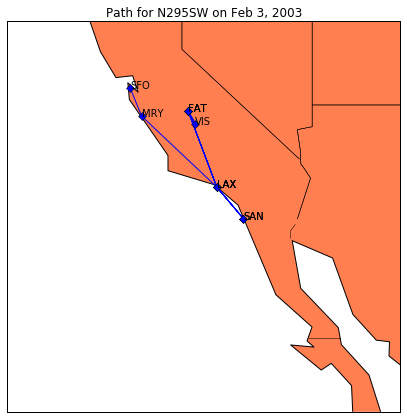

In [289]:
from mpl_toolkits.basemap import Basemap
from matplotlib import collections  as mc
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
%matplotlib inline


c = np.array([(1, 0, 0, 1), (0, 1, 0, 1), (0, 0, 1, 1)])
G = nx.Graph()
plt.rcParams["figure.figsize"] = [10,7]
map = Basemap(projection='merc',llcrnrlon=-128,llcrnrlat=25,urcrnrlon=-110,urcrnrlat=40)
x, y = map(top.oLong.values, top.oLat.values)
map.fillcontinents(color='coral',lake_color='aqua')

#x, y= top.oLong.values, top.oLat.values
map.plot(x,y, 'bo', markersize=3)
map.plot(x,y, 'D-', linewidth=1)
#map.plot(-119, 40, "y-", linewidth=2)
map.drawcoastlines()
map.drawstates()
labels = top.Origin.values
for label, xpt, ypt in zip(labels, x, y):
    plt.text(xpt, ypt, label)
    
plt.title("Path for N295SW on Feb 3, 2003")
plt.show()

Just shuttling around SoCal.

## Most distance on this day
Lets find and map of plane which logged the most distance on this day?
We'll need to add all the longitudes, latitudes and distances, group and sum by tail num, and sort them.


In [290]:
fl = fl.apply(addLatLongDist, axis=1)
longest = fl.groupby(["TailNum", "date"]).sum().sort_values(by="dist", ascending=False).head(15)[["dist"]]
longest

,,dist
TailNum,date,
N183UW,1044230400000000000,25779.679515
N551NW,1044230400000000000,16974.571634
N834MH,1044230400000000000,15680.475451
N839MH,1044230400000000000,15125.214452
N5EUAA,1044230400000000000,14697.811398
N69059,1044230400000000000,14250.238699
N524JB,1044230400000000000,13992.196745
N5DKAA,1044230400000000000,13855.015087
N5DEAA,1044230400000000000,13502.441676


N841MH seems to be the workhorse of the day. But theres no way one plane flew almost 10000 miles more than any other plane, lets check out its day.

In [291]:
rf = fl.TailNum == "N183UW"
tDist = fl[rf]
tDist = tDist.drop_duplicates('DepTime').sort_values(by="DepTime")
tDist[["Origin", "Dest", "DepTime", "ArrTime", "dist"]]

,Origin,Dest,DepTime,ArrTime,dist
595884,BOS,PIT,06:24:00,08:11:00,796.813900
585570,PHL,LAX,06:50:00,09:43:00,3857.526651
585669,CLT,LAX,08:21:00,10:37:00,3413.608076
601674,PIT,SFO,09:15:00,11:42:00,3619.403320
590602,LAX,PHL,10:44:00,18:25:00,3857.526651
574520,LAX,CLT,11:57:00,19:07:00,3413.608076
590834,SFO,PHL,12:39:00,20:29:00,4049.006335
584060,PHL,FLL,20:05:00,22:53:00,1601.136594
572196,CLT,BOS,20:22:00,22:18:00,1171.049910


This looks like two different planes. It can't be one, the times overlap. 

So I guess tail numbers arent unique? This is weird, and it definitely gets in the way of my ability to figure out the individual plane which flew the most if tail numbers arent unique. NOTE: i saw this with more than just this plane. Most planes at the top of the distance grouping looked like the records of multiple planes.  I'll need to write a function which determines whether the path given is valid for a single plane.

In [293]:
def isValidPath(df):
    atAirport = df.iloc[0]["Dest"]
    for i in range(1,len(df.index)):
        #if the origin of this flight doesnt equal the destination of the previous flight cant be valid
        if df.iloc[i]["Origin"] != atAirport:
            return False
        atAirport = df.iloc[i]["Dest"]
    return True


for p in longest.index:
    print(p[0])
    rf = fl.TailNum == p[0]
    tDist = fl[rf]
    tDist = tDist.drop_duplicates('DepTime').sort_values(by="DepTime")
    valid = isValidPath(tDist)
    if valid:
        print("This is one plane!!!", p[0])
        break
        
tDist[["Origin", "Dest", "DepTime", "ArrTime", "dist"]]

N183UW
N551NW
N834MH
N839MH
N5EUAA
('This is one plane!!!', u'N5EUAA')


,Origin,Dest,DepTime,ArrTime,dist
945514,DFW,BOS,06:22:00,10:33:00,2510.057843
929018,BOS,LAX,11:49:00,15:22:00,4194.351521
929046,LAX,OGG,16:45:00,19:52:00,3996.701017
927376,OGG,LAX,21:51:00,04:32:00,3996.701017


This looks like a valid plane, from Dallas -> Boston ->LA -> Hawaii -> LA, quite the day. What does that look like on a Map?

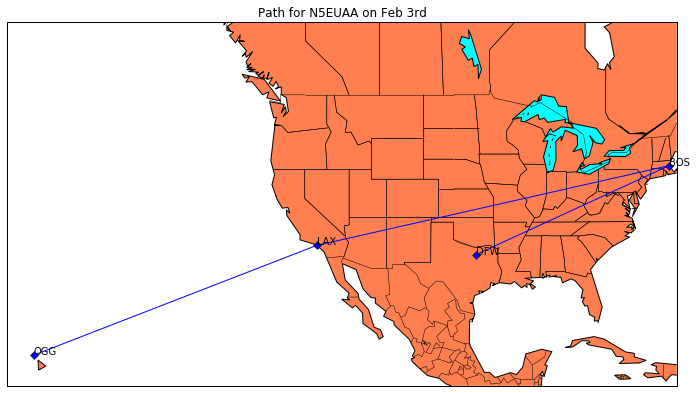

In [294]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
%matplotlib inline
plt.rcParams["figure.figsize"] = [12,9]


map = Basemap(projection='merc',llcrnrlon=-160,llcrnrlat=17,urcrnrlon=-70,urcrnrlat=55)
x, y = map(tDist.oLong.values, tDist.oLat.values)
map.fillcontinents(color='coral',lake_color='aqua')

#x, y= top.oLong.values, top.oLat.values
map.plot(x,y, 'bo', markersize=3)
map.plot(x,y, 'D-', linewidth=1)
#map.plot(-119, 40, "y-", linewidth=2)
map.drawcoastlines()
map.drawcountries()
map.drawstates()
labels = tDist.Origin.values
for label, xpt, ypt in zip(labels, x, y):
    plt.text(xpt, ypt, label)
    
plt.title("Path for N5EUAA on Feb 3rd")
plt.show()

# Looking at a while month and trends within

For the next few questions, i'm going to look at data for the whole month of January so single day anomalies don't get in the way. 


## Delays
First up, what airline has the worst delays



In [108]:
jan = flights[flights.Month == 1]
jan.head()

,Year,Month,DayofMonth,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,ArrDelay,Origin,Dest,TaxiIn,TaxiOut
0,2003,1,29,1651,1912,UA,1017,N202UA,-1,ORD,MSY,5,17
1,2003,1,30,1654,1910,UA,1017,N311UA,-3,ORD,MSY,2,26
2,2003,1,31,1724,1936,UA,1017,N317UA,23,ORD,MSY,5,17
3,2003,1,1,1033,1625,UA,1018,N409UA,-9,OAK,ORD,6,11
4,2003,1,2,1053,1726,UA,1018,N496UA,52,OAK,ORD,13,46


In [109]:
slow = jan.groupby("UniqueCarrier").mean().sort_values(by="ArrDelay")[["ArrDelay"]]
slow

,ArrDelay
UniqueCarrier,
AA,-1.738959
UA,-1.040655
NW,-0.726886
DL,0.596118
AS,0.933053
WN,0.982409
CO,1.447099
US,1.965705
B6,2.955364


Not too bad from the big carriers, while it seems not so large ones like Independence Air (DH) are slower. 

What about taxi times. If a plane taxis a lot it probably means their airlines arent renting the best gates. So which airlines spend the most time taxiing?



In [110]:
gp = jan.groupby("UniqueCarrier").mean()
gp["totTaxi"] = gp["TaxiIn"] + gp["TaxiOut"]
gp.sort_values(by="totTaxi")[["totTaxi"]]

,totTaxi
UniqueCarrier,
WN,13.165525
OO,15.295058
AS,18.039855
EV,19.084484
B6,21.379704
UA,21.588421
MQ,22.573911
US,22.701982
DH,22.829651


Bravo Southwest. Some big guys in last (Continental, Delta, American Airlines). These guys operate out of some big airports, so not too surprising, but so does Southwest, so this makes their wait times even more impressive. Guess they shell out for the nice gates. Alaska Airlines probably is one of the only airline operating out of their airports, so expect to see them high up. 


## Relationship between taxiTime and delay time

draw a scatter plot/cluster analysis


## Turning planes around for the next flight

When looking at how many times a single plane flew in a day, I realized that the most important part of this was how quickly an airline could get a landed flight back in the air. So who does this best? Do the airlines who do this best also see the most delays? That seems possible since one delay could cause a ripple affect throughout the day.

When doing this analysis i'll need to keep in mind the unique tail number issue, as well as the overlapping a->b->c as well as a->c mentioned earlier. I'll need to get rid of all a->c occurences first to fix that. Then with the unique tail number issue i'll need to make sure the only flights i'm looking at are those which the same tail number lands then takes off at the same airport.

Looking back for the previous flight for each flight becomes an O(n^2) computation, so i'm just going to look at the first week of January. First, lets sort by date and time as well as taking care of the a->c problem.

In [152]:
day = jan.DayofMonth < 8
jan1 = jan[day]
jan1 = jan1.sort_values(by=["DayofMonth", "DepTime", "ArrTime"]).drop_duplicates(subset = ["TailNum", "DepTime"])
jan1 = jan1.apply(addDate, axis=1)
jan1.head()

,Year,Month,DayofMonth,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,ArrDelay,Origin,Dest,TaxiIn,TaxiOut,date
484133,2003,1,1,00:03:00,02:29:00,AS,127,N780AS,57,SEA,ANC,4,11,1041379200000000000
275765,2003,1,1,00:05:00,01:30:00,DL,245,N375DA,243,OKC,SLC,4,17,1041379200000000000
485927,2003,1,1,00:05:00,02:30:00,AS,285,N969AS,130,LAX,SEA,7,8,1041379200000000000
551855,2003,1,1,00:09:00,06:39:00,DL,236,N660DL,-13,LAS,ATL,6,12,1041379200000000000
524045,2003,1,1,00:15:00,01:30:00,DH,7757,N663BR,151,IAD,CAE,3,13,1041379200000000000


In [155]:
def getTurnaroundTime(rw):
    #store turnTime which is a timedelta representing the time between a plane's flights
    prev = getPrevFlightForPlane(rw)
    FMT = "%H:%M"
    tt = 0
    if len(prev) == 1:
        tt = datetime.datetime.strptime(rw.DepTime.strftime(FMT), FMT) - datetime.datetime.strptime(prev.ArrTime.values[0].strftime(FMT), FMT)
        rw['turnTime'] = tt.total_seconds()
    else:
        rw["turnTime"] = None
    #print(rw['turnTime'], type(rw['turnTime']))
    return rw

def getPrevFlightForPlane(rw):
    global jan1
    #flight needs to be on the same day, earlier time, tailNumSame and org needs to equal prev dest, if doesnt exist make it None
    #comparing month and year so this is re-usable on a larger scale
    f = jan1[((jan1.TailNum == rw.TailNum) & (jan1.DayofMonth == rw.DayofMonth) & (jan1.Year == rw.Year) & (jan1.Month == rw.Month) & (jan1.DepTime < rw.DepTime) & (jan1.Dest == rw.Origin))].tail(1)
    return f
    
    return False

random = jan1.iloc[12437]
print(random[["TailNum", "DepTime", "ArrTime", "Origin", "Dest", "DayofMonth", "UniqueCarrier"]])
getPrevFlightForPlane(random)[["TailNum", "DepTime", "ArrTime", "Origin", "Dest", "DayofMonth", "UniqueCarrier"]]

TailNum            N925SW
DepTime          18:05:00
ArrTime          20:32:00
Origin                LAX
Dest                  PHX
DayofMonth              1
UniqueCarrier          OO
Name: 187274, dtype: object


,TailNum,DepTime,ArrTime,Origin,Dest,DayofMonth,UniqueCarrier
187283,N925SW,15:46:00,16:52:00,SJC,LAX,1,OO


In [156]:
jan1 = jan1.apply(getTurnaroundTime, axis=1)
jan1.head()

,Year,Month,DayofMonth,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,ArrDelay,Origin,Dest,TaxiIn,TaxiOut,date,turnTime
484133,2003,1,1,00:03:00,02:29:00,AS,127,N780AS,57,SEA,ANC,4,11,1041379200000000000,NaN
275765,2003,1,1,00:05:00,01:30:00,DL,245,N375DA,243,OKC,SLC,4,17,1041379200000000000,NaN
485927,2003,1,1,00:05:00,02:30:00,AS,285,N969AS,130,LAX,SEA,7,8,1041379200000000000,NaN
551855,2003,1,1,00:09:00,06:39:00,DL,236,N660DL,-13,LAS,ATL,6,12,1041379200000000000,NaN
524045,2003,1,1,00:15:00,01:30:00,DH,7757,N663BR,151,IAD,CAE,3,13,1041379200000000000,NaN


In [159]:
fastestTurn = jan1.groupby("UniqueCarrier").mean()
fastestTurn['turnTime'].sort_values()

UniqueCarrier
WN    2204.099629
FL    2967.066532
B6    3757.661748
MQ    3771.082391
DH    3930.741168
OO    3939.242193
US    4286.865821
XE    4478.083740
TZ    4699.596200
NW    4764.393112
UA    4773.715282
AA    4781.773043
AS    4795.852941
HP    4799.095364
DL    4813.350751
EV    4973.141962
CO    5185.356843
Name: turnTime, dtype: float64

Southwest gets its planes back out the door the fastest, in less than an hour! Much faster than even the second fastest, AirTran. Not too surprising to see the larger airlines at the top of this list. But how does a high turnaround time correlate with delays? Lets look at a plot.

### Does fastest turnaround mean more delays?

If an airlines schedule depends on then turning planes around quickly, then this could mean that tighter turnarounds mean more delays. Lets examine this relationship.

In [176]:
tt = fastestTurn['turnTime']
cc = slow.join(tt)

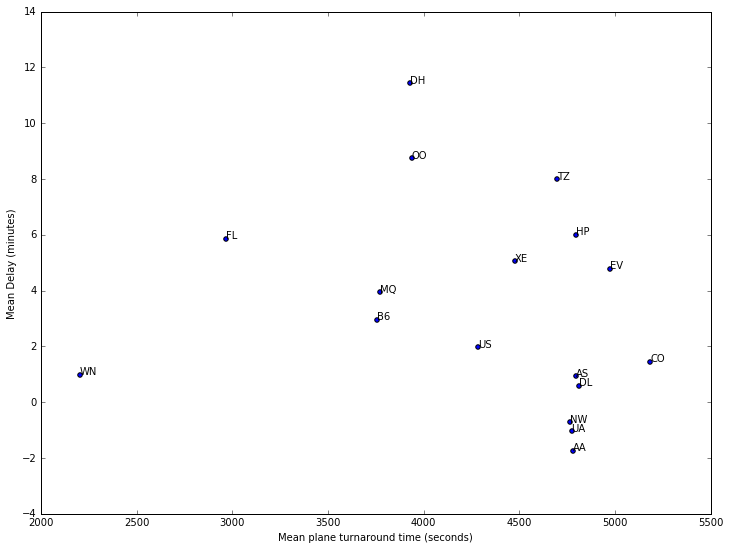

In [174]:
import matplotlib.pyplot as plt

x = cc['turnTime']
y = cc['ArrDelay']
lab = cc.index

fig, ax = plt.subplots()
ax.scatter(x, y)
plt.xlabel("Mean plane turnaround time (seconds)")
plt.ylabel("Mean Delay (minutes)")

for i, txt in enumerate(lab):
    ax.annotate(txt, (x[i],y[i]))

No real discernable trend here. Southwest is certainly an outlier, Independence Air was awful. In this rudimentary analysis, it is not clear that faster turnaround times mean more delays.